# 生成對抗網路（Generative Adversarial Network, GAN）
![DCGAN](https://miro.medium.com/max/700/0*5T-TQoLIdz5NAuqm.png)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import load_model

In [2]:
# 定義寬高與通道數
img_rows = 28
img_cols = 28
channels = 1

# 輸入維度（Input image dimensions）
img_shape = (img_rows, img_cols, channels)

# 定義亂數大小作為生成器的輸入（Size of the noise vector, used as input to the Generator）
z_dim = 100

## 生成器（Generator）

In [3]:
# 建立生成器模型
def build_generator(img_shape, z_dim):
    
    # 建立順序式模型
    model = Sequential()

    # 加入全連接層（Fully connected layer）
    model.add(Dense(128, input_dim=z_dim))

    # 加入Leaky-ReLU激勵函數 （Leaky ReLU activation）
    model.add(LeakyReLU(alpha=0.01))

    # 加入具有tanh激勵函數的輸出層 （Output layer with tanh activation）
    model.add(Dense(28 * 28 * 1, activation='tanh'))

    # 更改生成器的輸出影像大小 （Reshape the Generator output to image dimensions）
    model.add(Reshape(img_shape))

    return model

## 鑑別器（Discriminator）

In [4]:
# 建立鑑別器模型
def build_discriminator(img_shape):

    # 建立順序式模型
    model = Sequential()

    # 加入展開的輸入影像（Flatten the input image）
    model.add(Flatten(input_shape=img_shape))

    # 加入全連接層（Fully connected layer）
    model.add(Dense(128))

    # 加入Leaky-ReLU激勵函數 （Leaky ReLU activation）
    model.add(LeakyReLU(alpha=0.01))

    # 加入具有sigmoid激勵函數的輸出層 （Output layer with sigmoid activation）
    model.add(Dense(1, activation='sigmoid'))

    return model

## 建立模型（Build the Model）

In [5]:
# 建立Gan模型
def build_gan(generator, discriminator):

    # 建立順序式模型
    model = Sequential()

    # 結合生成器（先）與鑑別器（後）（Combined Generator -> Discriminator model）
    model.add(generator)
    model.add(discriminator)

    return model

In [6]:
# 呼叫鑑別器建立模型之方法，並編譯鑑別器的損失函數與優化方法（Build and compile the Discriminator）
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# 呼叫生成器建立模型之方法（Build the Generator）
generator = build_generator(img_shape, z_dim)

# 固定鑑別器的參數不變以進行生成器訓練（Keep Discriminator’s parameters constant for Generator training）
# (非常重要)
discriminator.trainable = False

# 以固定鑑別器之編譯GAN模型來訓練生成器（Build and compile GAN model with fixed Discriminator to train the Generator）
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## 建立訓練方式（Training）


In [7]:
losses = []
accuracies = []
iteration_checkpoints = []

# 訓練
def train(iterations, batch_size, sample_interval):

    # 讀取MNIST數字手寫，只保留Train影像（Load the MNIST dataset）
    (X_train, _), (_, _) = mnist.load_data()

    # 將灰階像素以正規化投影至-1與1之間（Rescale [0, 255] grayscale pixel values to [-1, 1]）
    X_train = X_train / 127.5 - 1.0

    # 增加一維度（像素增加一括弧）（axis=3 同等於 -1）
    X_train = np.expand_dims(X_train, axis=3) 

    # 建立為真的影像之Lable（Labels for real images: all ones）
    real = np.ones((batch_size, 1))

    # 建立為假的影像之Lable（Labels for fake images: all zeros）
    fake = np.zeros((batch_size, 1))

    # 迭代次數
    for iteration in range(iterations):

        # ----------------------------------
        #  訓練鑑別器（Train the Discriminator）
        # ----------------------------------

        # 亂數抽取真的影像（Get a random batch of real images）
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # 亂數的向量來生成假的影像（Generate a batch of fake images）
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # 鑑別器的訓練（Train Discriminator）（train_on_batch 同樣 fit）
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ----------------------------------
        #  訓練生成器（Train the Generator）
        # ----------------------------------

        # 生成器來生成假的影像（Generate a batch of fake images）
        z = np.random.normal(0, 1, (batch_size, 100)) # 平均值為零，寬度為一，大小為batch_size個的長度100的陣列
        gen_imgs = generator.predict(z) # 生成器生成影像

        # 生成器的訓練（Train Generator）
        g_loss = gan.train_on_batch(z, real)

        # 打印訓練結果（每 sample_interval 次就打印一次）
        if (iteration + 1) % sample_interval == 0:

            # 儲存每次第 sample_interval 次的損失、準確度與迭代次數，方便於後繪圖
            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # 打印訓練的結果（Output training progress）
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # 打印訓練過程的影像（Output a sample of generated image）
            sample_images(generator)

            # 儲存模型
            discriminator.save('discriminator_%d.h5' %(iteration + 1))
            generator.save('generator_%d.h5' %(iteration + 1))

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 生成四乘四的亂數數量，長度為100（Sample random noise）
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 生成器生成影像（Generate images from random noise）
    gen_imgs = generator.predict(z)

    # 生成的像素投影為0,1之間（Rescale image pixel values to [0, 1]）
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 繪製子網格來呈現生成影像（Set image grid）
    fig, axs = plt.subplots(image_grid_rows,image_grid_columns,figsize=(4, 4),sharey=True,sharex=True)

    # 迴圈依序放置影像
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## 呈現訓練過程（Train the GAN and Inspect Output）

Note that the `'Discrepancy between trainable weights and collected trainable'` warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

11493376/11490434 [==============================] - 0s 0us/step
1000 [D loss: 0.046181, acc.: 99.61%] [G loss: 3.605886]
2000 [D loss: 0.133953, acc.: 94.92%] [G loss: 5.312936]
3000 [D loss: 0.115586, acc.: 94.53%] [G loss: 3.868747]
4000 [D loss: 0.161319, acc.: 93.36%] [G loss: 3.784981]
5000 [D loss: 0.287353, acc.: 89.06%] [G loss: 3.158463]
6000 [D loss: 0.383149, acc.: 85.16%] [G loss: 3.759585]
7000 [D loss: 0.317553, acc.: 87.50%] [G loss: 3.113537]
8000 [D loss: 0.358664, acc.: 85.94%] [G loss: 3.710212]
9000 [D loss: 0.490301, acc.: 80.08%] [G loss: 2.775114]
10000 [D loss: 0.599154, acc.: 78.91%] [G loss: 3.715579]
11000 [D loss: 0.282021, acc.: 88.28%] [G loss: 3.663132]
12000 [D loss: 0.415847, acc.: 81.64%] [G loss: 3.595097]
13000 [D loss: 0.464711, acc.: 82.03%] [G loss: 2.254632]
14000 [D loss: 0.287924, acc.: 89.06%] [G loss: 3.336899]
15000 [D loss: 0.370504, acc.: 85.55%] [G loss: 2.594138]
16000 [D loss: 0.332669, acc.: 86.72%] [G loss: 2.860487]
17000 [D loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


22000 [D loss: 0.429924, acc.: 78.91%] [G loss: 2.175685]
23000 [D loss: 0.382233, acc.: 84.38%] [G loss: 2.926995]
24000 [D loss: 0.430522, acc.: 81.64%] [G loss: 2.208963]
25000 [D loss: 0.429498, acc.: 80.08%] [G loss: 2.068574]
26000 [D loss: 0.433646, acc.: 78.12%] [G loss: 2.489388]
27000 [D loss: 0.373266, acc.: 83.98%] [G loss: 2.369417]
28000 [D loss: 0.492591, acc.: 76.56%] [G loss: 2.355614]
29000 [D loss: 0.362668, acc.: 85.94%] [G loss: 2.230793]
30000 [D loss: 0.378839, acc.: 84.38%] [G loss: 2.184660]
31000 [D loss: 0.437592, acc.: 78.91%] [G loss: 2.136371]
32000 [D loss: 0.488302, acc.: 78.91%] [G loss: 1.950883]
33000 [D loss: 0.474905, acc.: 78.52%] [G loss: 1.983602]
34000 [D loss: 0.406729, acc.: 82.03%] [G loss: 2.407969]
35000 [D loss: 0.345095, acc.: 85.16%] [G loss: 2.745299]
36000 [D loss: 0.467348, acc.: 76.17%] [G loss: 2.680289]
37000 [D loss: 0.296592, acc.: 89.84%] [G loss: 2.874494]
38000 [D loss: 0.425401, acc.: 77.73%] [G loss: 2.469652]
39000 [D loss:

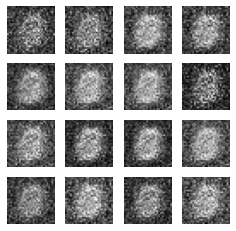

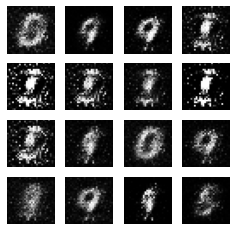

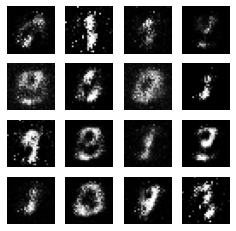

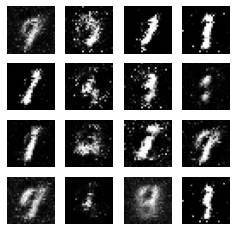

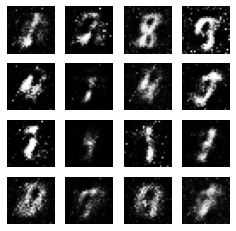

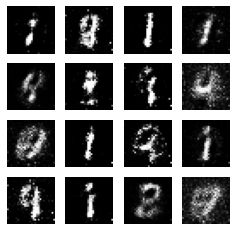

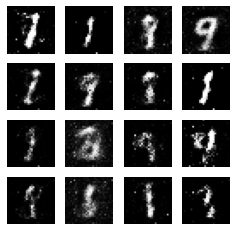

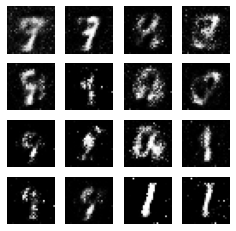

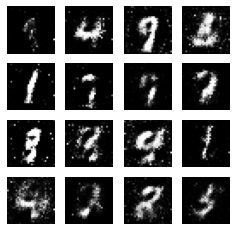

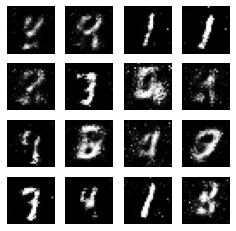

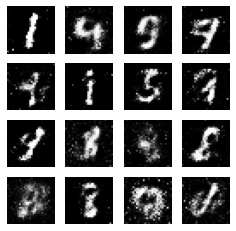

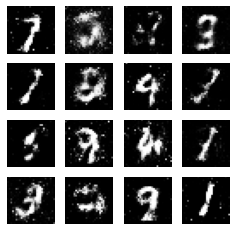

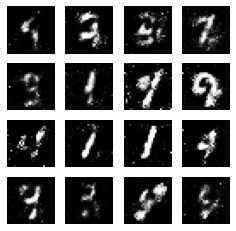

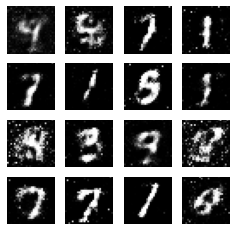

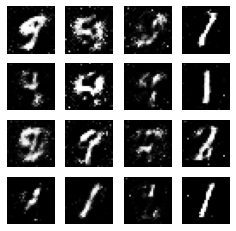

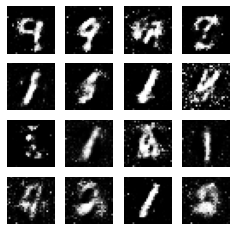

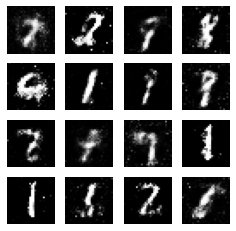

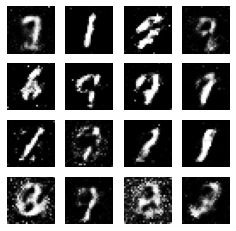

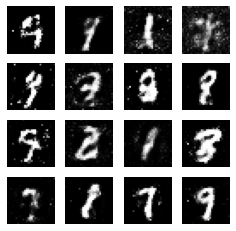

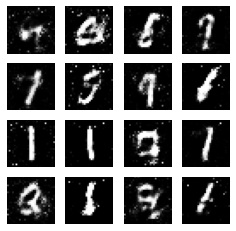

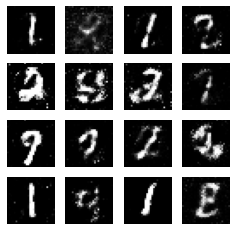

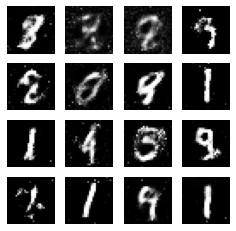

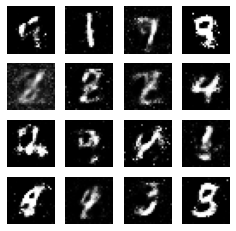

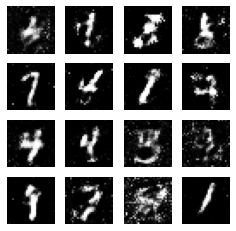

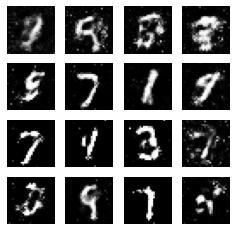

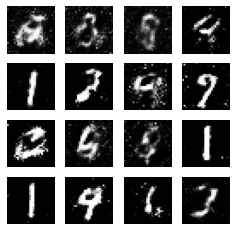

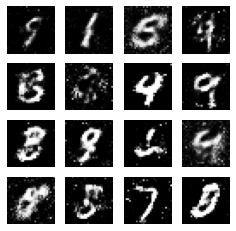

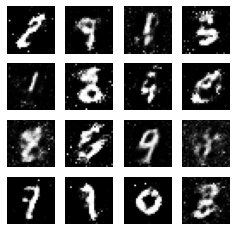

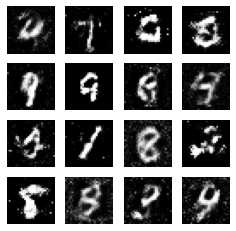

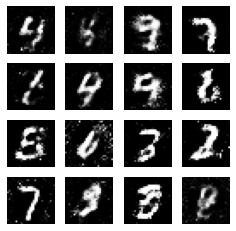

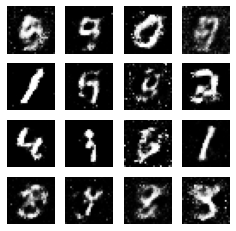

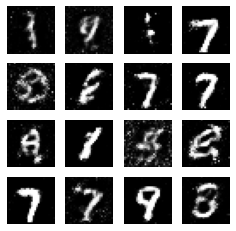

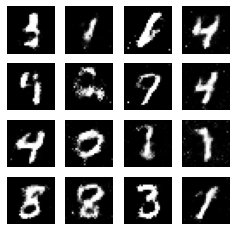

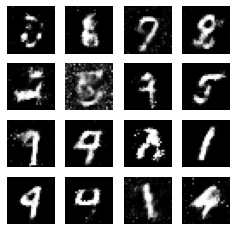

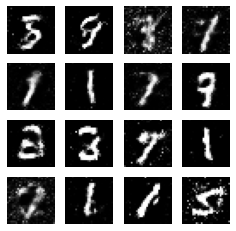

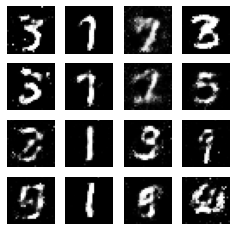

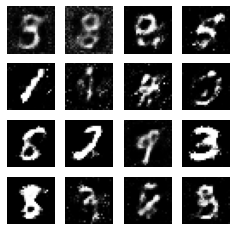

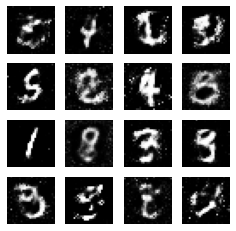

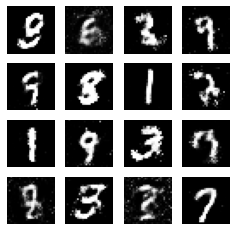

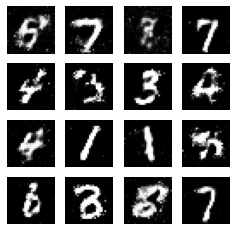

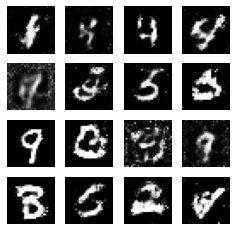

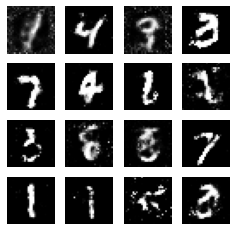

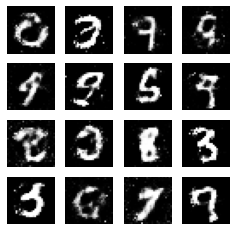

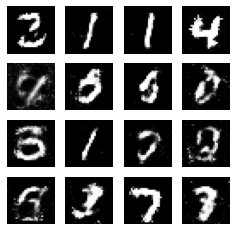

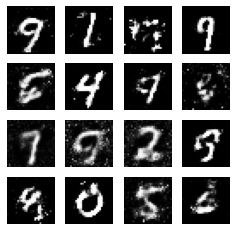

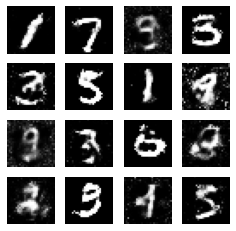

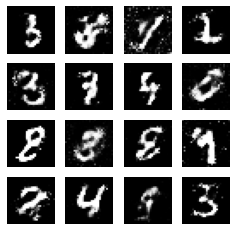

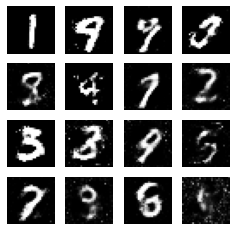

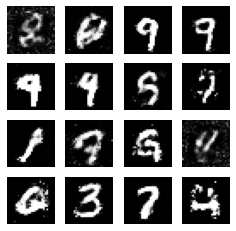

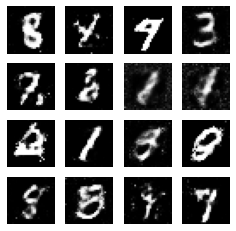

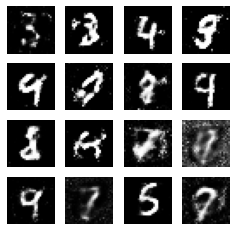

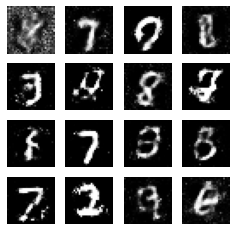

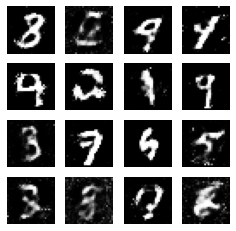

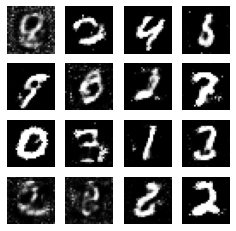

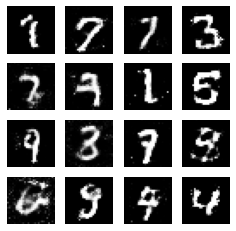

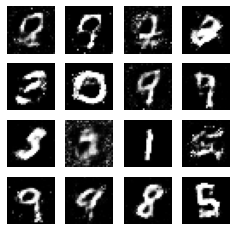

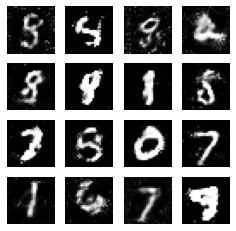

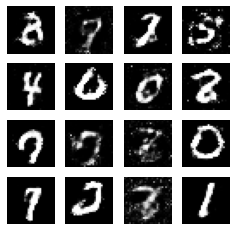

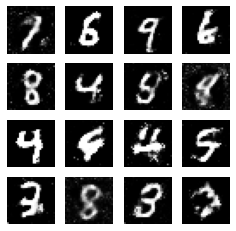

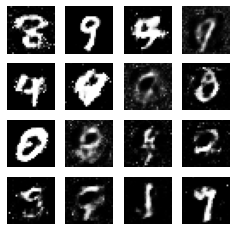

In [9]:
# 設置超參數（Set hyperparameters）
iterations = 60000
batch_size = 128
sample_interval = 1000

# 開始訓練（Train the GAN for the specified number of iterations）
train(iterations, batch_size, sample_interval)

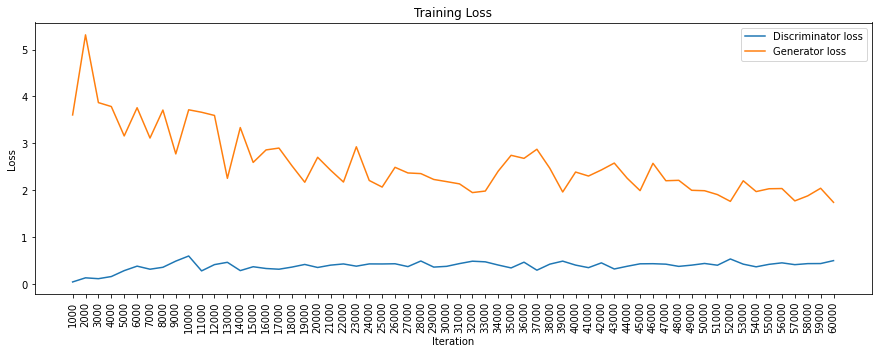

In [10]:
losses = np.array(losses)

# 繪製鑑別器與生成器的訓練損失圖（Plot training losses for Discriminator and Generator）
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

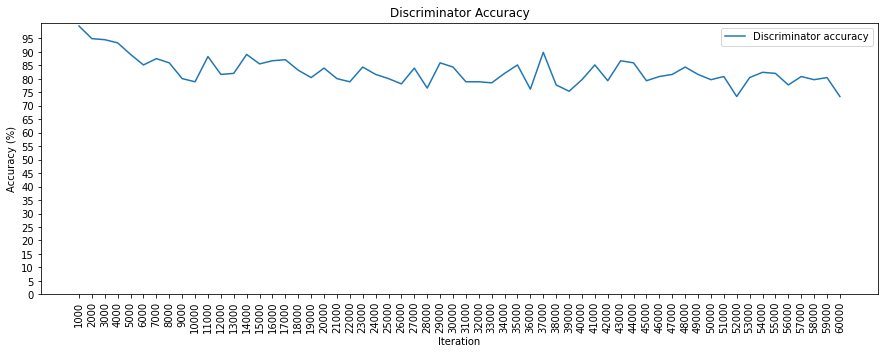

In [11]:
accuracies = np.array(accuracies)

# 繪製鑑別器的準確度（Plot Discriminator accuracy）
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

生成器輸出的影像維度： (1, 28, 28, 1)
重新改變大小影像維度： (28, 28)


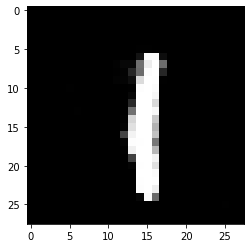

In [17]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

generator = load_model('generator_60000.h5', compile=False)

z = np.random.normal(0, 1, (1, 100))
gen_imgs = generator.predict(z)
print("生成器輸出的影像維度：", gen_imgs.shape)

res_img = gen_imgs.reshape(28,28)
print("重新改變大小影像維度：", res_img.shape)

plt.imshow(res_img, cmap='gray')
plt.show()